### Исходное задание 
1. нужно скачивать информацию о блоке и сохранять (чтобы каждый раз не тянуть данные, а если нужно то подгрузить, лучше в несколько потоков)
http://93.125.26.210:34657/block?height=300
2. далее распарсить итеративно все блоки и сохранить информацию о коммитах для каждого валидатора для каждого блока
3. нарисовать графики для валидаторов, график лайфтайма
4. расчитать вознаграждение для каждого исходя из линейно возрастающей награды за каждый блок
5. выдать таблицу - валидатор, баланс

In [1]:
import pandas as pd

In [2]:
from tqdm import tqdm_notebook

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import plotly.graph_objects as go

In [5]:
import numpy as np

In [6]:
import numpy as np
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [7]:
# validators_df = pd.read_csv("euler_validators_2.csv", usecols=["block", "validators"])

In [8]:
# validators_df[["block", "validators"]].to_csv("euler_validators.csv")

In [9]:
validators_df = pd.read_csv("euler_validators.csv")

In [10]:
validators_df["validators"] = validators_df["validators"].apply(lambda x: eval(x))

In [62]:
validators_df["validators"] = validators_df["validators"].apply(lambda x: set(x))

In [60]:
all_validators = set([v for v_list in validators_df["validators"].tolist() for v in v_list])

### Визуализация работы валидаторов

In [13]:
# Последний актуальный блок
MAX_BLOCK = validators_df["block"].max()
MAX_BLOCK

3665414

In [14]:
validators_df["rounded_block"] = validators_df["block"].round(-4)

In [15]:
validators_df["rounded_block"].nunique()

368

In [16]:
x = validators_df["rounded_block"].unique().tolist()

In [17]:
all_y = []
labels = []
validator_traces = {}
for validator in tqdm_notebook(all_validators):
    validators_df["validator_mask"] = validators_df["validators"].apply(lambda x: validator in x).astype(float)
    y = validators_df.groupby("rounded_block")["validator_mask"].sum().tolist()
    all_y.append(y)
    labels.append(validator)
    validator_traces[validator] = y

In [18]:
import matplotlib
cmap = matplotlib.cm.get_cmap('jet')

In [19]:
validator_colors = {
    validator: "rgba({})".format(", ".join([str(int(color * 255)) for color in cmap(np.sum(trace) / MAX_BLOCK)]))
    for validator, trace in validator_traces.items()
}

In [20]:
fig = go.Figure()

for validator, y in validator_traces.items():
    fig.add_trace(go.Scatter(
        x=x, y=y,
        mode='lines',
        name=validator[0:5] + "...",
        line=dict(width=0.5, color=validator_colors[validator]),
        stackgroup='one',
        groupnorm='percent'
    ))

fig.update_layout(
    showlegend=True,
    xaxis_type='linear',
    yaxis=dict(
        type='linear',
        range=[1, 100],
        ticksuffix='%'))

fig.show()

![](history.png)

### Расчет вознаграждения для каждого валидатора

In [348]:
from itertools import product

In [349]:
# Количество токенов, участвующее в раздаче
AMOUNT_OF_TOKENS = 10000000

In [350]:
validators_df["total_validators"] = validators_df["validators"].apply(lambda x: len(x))

In [378]:
b_step_simple_range = np.logspace(0, 10, 10)

In [379]:
def linear(block, k, b):
    return k * block + b

In [381]:
validators_df["rounded_block"] = validators_df["block"].round(-5)

In [ ]:
all_rewards = {}

for b in tqdm_notebook(b_step_simple_range):
    validators_df["total_reward"] = validators_df["block"].apply(lambda x: linear(x, 1, b)) 
    validators_df["validator_reward"] = validators_df["total_reward"] / validators_df["total_validators"] / validators_df["total_reward"].sum()

    rewards = {}
    for validator in tqdm_notebook(all_validators):
        validator_reward = validators_df[validators_df["validators"].apply(lambda x: validator in x)].groupby("rounded_block")["validator_reward"].sum()
        rewards[validator] = (validator_reward * AMOUNT_OF_TOKENS).to_dict()
        
    all_rewards[b] = rewards

In [387]:
sorted_validators = sorted(all_validators, key=lambda x: sum(all_rewards[1.0][x].values()))

В массиве - сколько каждый из валидаторов набрал по всем диапазонам блоков (включая пропуски)

In [394]:
def show_rewards_by_block(all_rewards, margin=0):
    values = []
    for block_range in validators_df["rounded_block"].unique():
        values.append([])
        for validator in sorted_validators:
            values[-1].append(all_rewards[validator].get(block_range, 0))

    cmap = matplotlib.cm.get_cmap('Reds')
    ind = np.arange(len(all_validators))    
    width = 0.08
    blocks_number = validators_df["rounded_block"].nunique()
    
    bottom_values = np.zeros(len(values[0]))
    for index, values_row in enumerate(values):
        plt.barh(ind - margin * width, values_row, width, color=cmap(index / blocks_number), left=bottom_values)
        bottom_values += values_row

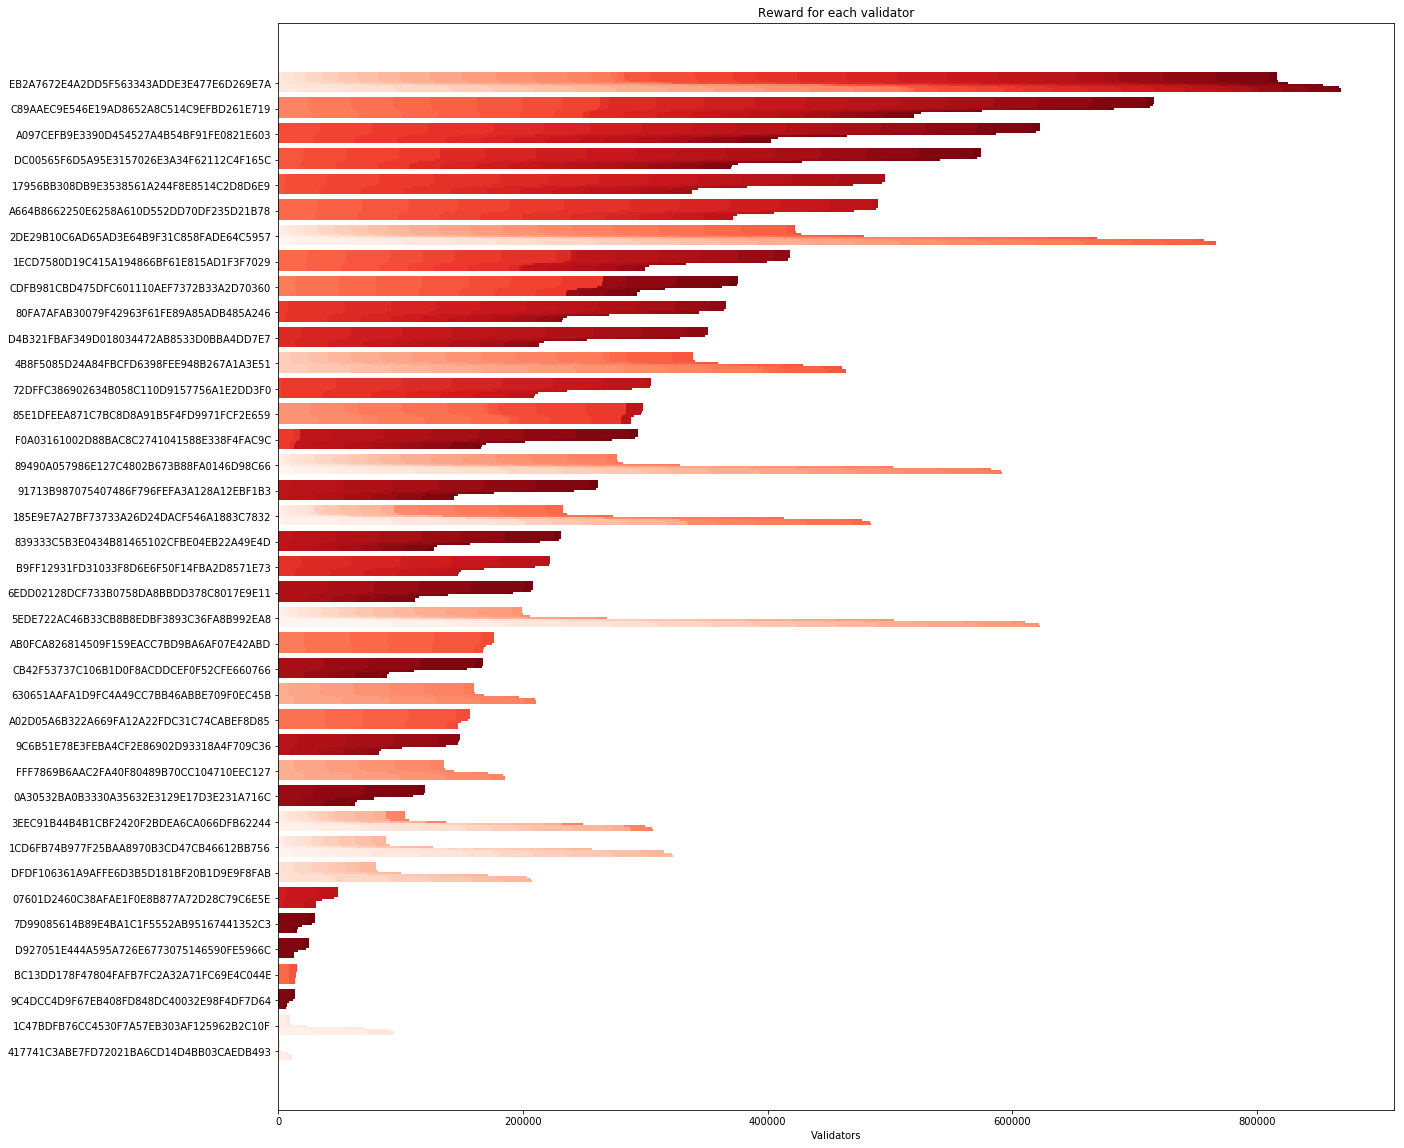

In [406]:
plt.figure(figsize=(20, 20))

for i, b in enumerate(b_step_simple_range):
    show_rewards_by_block(all_rewards[b], i)
    
plt.xlabel('Validators')
plt.title('Reward for each validator')
indices = np.arange(len(all_validators)) - 0.08 * 0.5 * len(b_step_simple_range)
plt.yticks(indices, sorted_validators)
plt.show()

Для каждого валидатора
- Более темным цветом показана часть вознаграждения, полученная за более поздние блоки
- Сверху вниз показано изменение вознаграждения при увеличении коэффициента $\frac{B}{K}$

### Вывод

При форме вознаграждения $reward = K*height+B$ и увеличении значения $\frac{B}{K}$
- новые валидаторы получают меньше;
- старые валидаторы получают больше.

На объем вознаграждения влияет только соотношение $\frac{B}{K}$, а не отдельно $B$ и $K$

# Визуализация балансов

In [498]:
K = 1
B = 0

In [499]:
validators_df["total_reward"] = validators_df["block"].apply(lambda x: linear(x, K, B)) 
validators_df["validator_reward"] = validators_df["total_reward"] / validators_df["total_validators"] / validators_df["total_reward"].sum()

selected_rewards = {}
for validator in tqdm_notebook(all_validators):
    validator_reward = validator_reward_part[validators_df["validators"].apply(lambda x: validator in x)].sum()
    selected_rewards[validator] = validator_reward

In [516]:
sorted_validators = sorted(all_validators, key=lambda x: selected_rewards[x])

In [517]:
data = [selected_rewards[v] for v in sorted_validators]

In [518]:
# Здесь можно указать имена валидаторов
validator_names = {
    sorted_validators[-1]: "That guy"
}

In [519]:
def get_name(i):
    validator_address = sorted_validators[i]
    main_name = validator_names.get(validator_address, validator_address[0:5] + "...")
    return main_name + " ({0:.2f}%)".format(selected_rewards[validator_address] * 100)

In [520]:
captions = [get_name(i) for i in range(len(sorted_validators))]

In [521]:
# Здесь можно указать, какое количество валидаторов в конце списка нужно объединить
OMITTED = 15
data = [sum(data[:OMITTED])] + data[OMITTED:]
captions = ["\n".join(captions[:OMITTED])] + captions[OMITTED:]

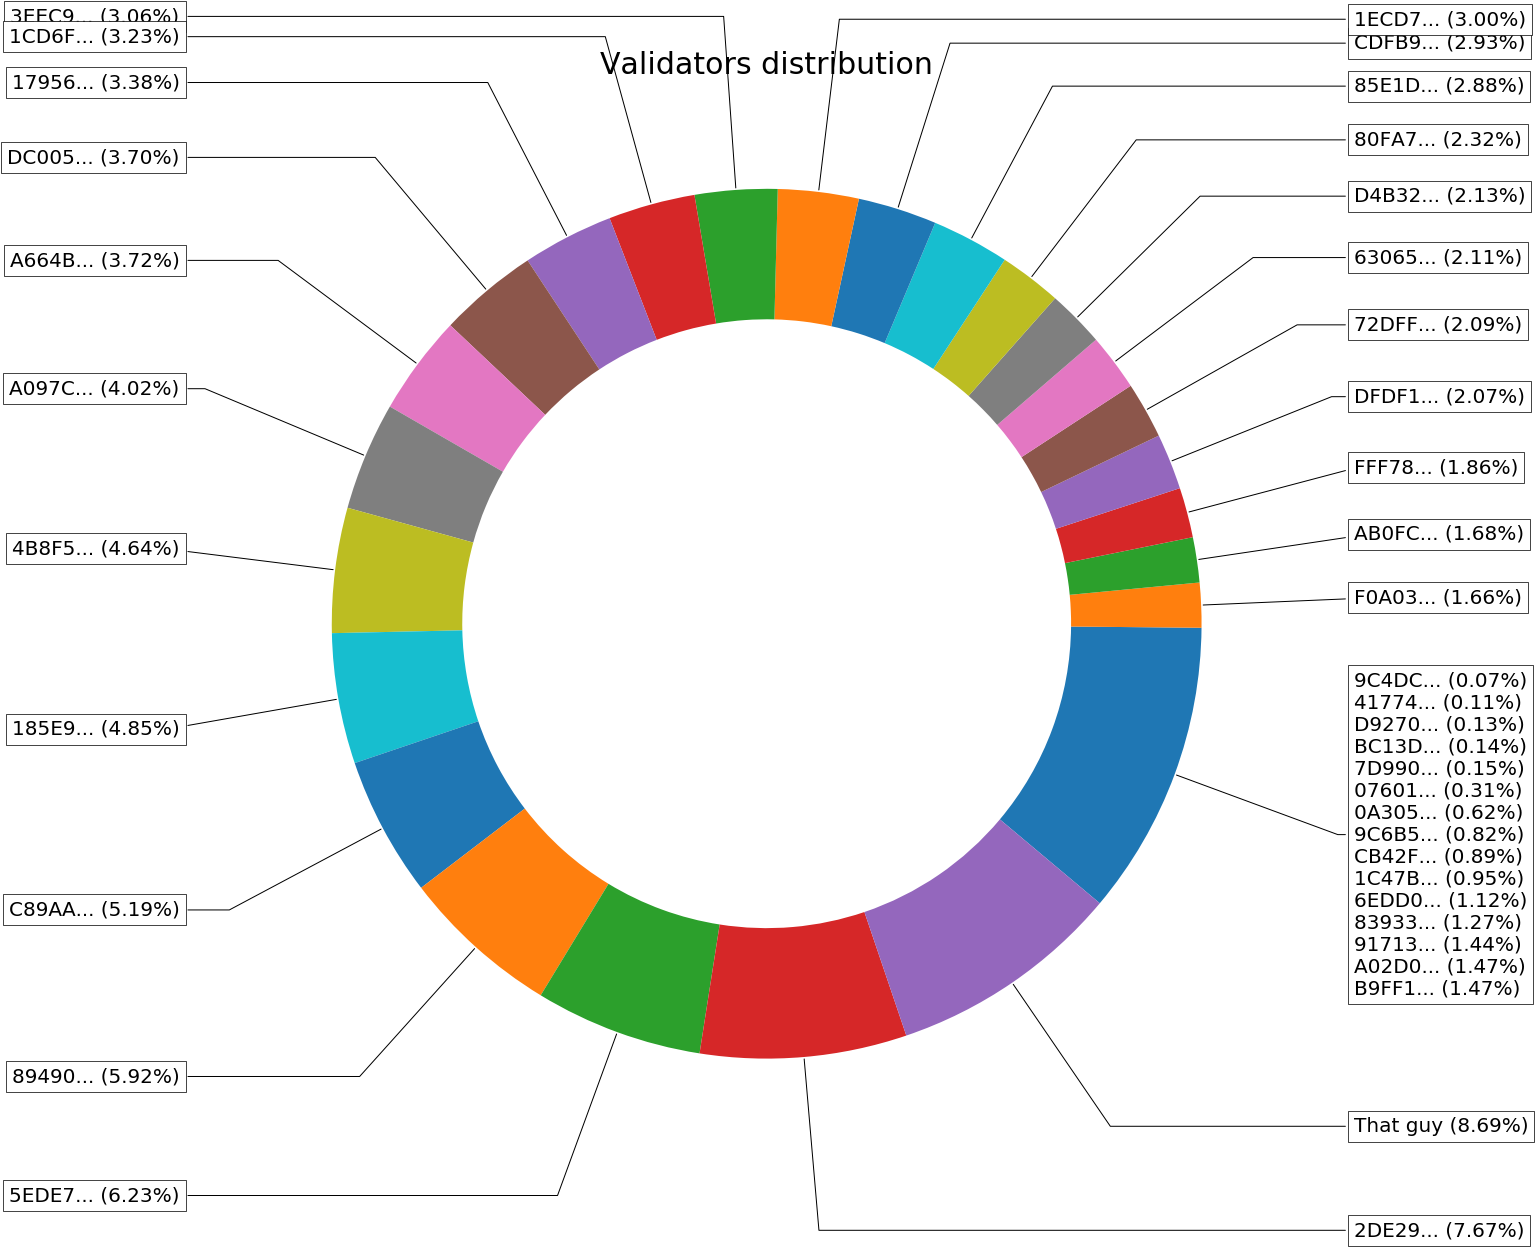

In [522]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw=dict(aspect="equal"))

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.3), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(captions[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, fontsize=20, **kw)

ax.set_title("Validators distribution", fontsize=30)

plt.show()